Importing libraries and models

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
!ls
%cd drive/'MyDrive'/SAiDL

'Computer vision assignment.ipynb'   ipykernel_launcher.py_plot.png
 data				    'Reinforcement learning assignment.ipynb'
[Errno 2] No such file or directory: 'drive/MyDrive/SAiDL'
/content/drive/MyDrive/SAiDL


In [80]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
#from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
#from torch.optim import Adam, SGD

# Keres libraries and modules
import sys
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

Importing STL 10 as training, test and unlabeled data

sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)


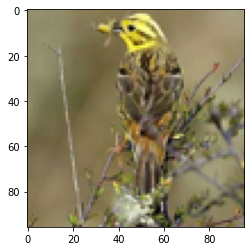

(5000, 96, 96, 3)
(5000,)


In [81]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
    
if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from scipy.misc import imsave

print(sys.version_info) 

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1
    
if __name__ == "__main__":
    # download data if needed
    # download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk

Spliting images into train, test, and unlabeled

In [108]:
# Using indices to split data
test_ind = round(len(images)*0.25)
train_ind = test_ind + round(len(images)*0.01)
unlabeled_ind = train_ind + round(len(images)*0.74)

test = images[0:test_ind,:,:,:]
train = images[test_ind:train_ind,:,:,:]
unlabeled = images[train_ind:unlabeled_ind,:,:,:]
train_supervised = images[test_ind:unlabeled_ind,:,:,:]

#Using indices to split labels
test_labels = labels[0:test_ind]
train_labels = labels[test_ind:train_ind]
unlabeled_lables = labels[train_ind:unlabeled_ind]
train_supervised_lables = labels[test_ind:unlabeled_ind]

# One-hot encoding
test_labels = to_categorical(test_labels)
train_labels = to_categorical(train_labels)
unlabeled_lables = to_categorical(unlabeled_lables)
train_supervised_lables = to_categorical(train_supervised_lables)

print(test_ind)
print(train_ind)
print(unlabeled_ind)

1250
1300
5000


In [83]:
# Scaling pixels
# convert from integers to floats
train_norm = train.astype('float32')
test_norm = test.astype('float32')
unlabeled_norm = unlabeled.astype('float32')
train_supervised_norm = train_supervised.astype('float32')
# normalize to range 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0
unlabeled_norm = unlabeled_norm/255.0
train_supervised_norm = train_supervised_norm/255.0

In [129]:

# Defining a Cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(96,96,3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(11, activation='softmax'))
  # model.add(Dense(64, input_dim=64, kernel_regularizer=regularizers.l2(0.01)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


Plotting graphs

In [85]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [116]:
print(test.shape)
print(len(test_labels))
print(len(train_labels))
print(len(unlabeled_lables))

(1250, 96, 96, 3)
1250
50
3700


Running a supervised model

In [88]:
supervised_model = define_model()
history_supervised_model = supervised_model.fit(train_supervised_norm, train_supervised_lables, epochs=200, batch_size=100, validation_data=(test_norm, test_labels), verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [89]:
# evaluate model
ab, acc = supervised_model.evaluate(test, test_labels, verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history_supervised_model)

> 44.880


Semi-supervised learning code

In [91]:
semi_supervised_model_prev = define_model()
history_semi_supervised_model_prev = semi_supervised_model_prev.fit(train_norm, train_labels, epochs=100, batch_size=100, validation_data=(test_norm, test_labels), verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [92]:
# evaluate model
ab, acc = semi_supervised_model.evaluate(test, test_labels, verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history_supervised_model)

> 18.400


In [121]:
pred_sup = semi_supervised_model.predict(train_norm)
pred_test = semi_supervised_model.predict(test_norm)
pred_unlabeled = semi_supervised_model.predict(unlabeled_norm)

# print(pred_sup)
# print(pred_test)

# Training labels for semi-supervised learning
train_semisupervised_labels = labels[test_ind:unlabeled_ind]
train_semisupervised_labels = to_categorical(train_semisupervised_labels)
train_semisupervised_labels[50:unlabeled_ind] = pred_unlabeled

print(train_semisupervised_labels.shape)
print(pred_unlabeled.shape)
print(train_semisupervised_labels[50:unlabeled_ind].shape)

(3750, 11)
(3700, 11)
(3700, 11)


In [124]:
semi_supervised_model_post = define_model()
history_semi_supervised_model_post = semi_supervised_model_post.fit(train_supervised_norm, train_semisupervised_labels, epochs=200, batch_size=100, validation_data=(test_norm, test_labels), verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [123]:
# evaluate model
ab, acc = semi_supervised_model_post.evaluate(test, test_labels, verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history_semi_supervised_model_post)

> 18.800


Unsupervised learning:

In [128]:
!git clone https://github.com/deu30303/RUC

Cloning into 'RUC'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 51 (delta 19), reused 23 (delta 3), pack-reused 0
Unpacking objects: 100% (51/51), done.


**Overall results:**

1.   *Supervised:* 45% accuracy
2.   *Semisupervised:* 18.8% accuracy

References other than that given in the question (i.e. used code from:)


In [ ]:
# 1) https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/